In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 8
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(0).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
def make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate, num_training,
                           num_nodes_fc, activation_type):
    hparam = ""

    # Hyper-parameters
    if USE_DATA_AUG:
        hparam += "AUG_"

    hparam += str(num_nodes_fc) + "nodes_" + str(learning_rate_base) + "lr_" + str(batch_size) + "batch_" + str(
        kernel_size) + "kernel_" + str(dropout_rate) + "drop_" + str(
        num_training) + "train_" + activation_type

    return hparam

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.clim(0,sum(cm[0,:]))
    plt.xlabel('Predicted label')

In [23]:
def top_K_classification_accuracy(y_predicted, y_true, K=1):

    num_samples = y_predicted.shape[0]
    num_classes = y_predicted.shape[1]

    if K > num_classes:
        sys.exit(1)

    temp = np.zeros((num_samples,))

    for idx in range(num_samples):
        curr_predicted = np.argsort(y_predicted[idx,:])
        curr_predicted = curr_predicted[::-1] # descending

        if y_true[idx] in curr_predicted[:K]:
            temp[idx] = 1

    return 100.0 * np.sum(temp)/num_samples

In [24]:
def conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    x_orig = x

    # Batch norm
    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 3x3 Conv2D
    x = Conv2D(num_filters_first_conv1D, kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)

    # 1x1 Conv2D
    x = Conv2D(num_filters_first_conv1D*4, kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x)

    # Skip connection
    if int(x.shape[3]) != int(x_orig.shape[3]):
        x_orig = Conv2D(int(x.shape[3]), kernel_size=1, activation=None, use_bias=False, padding='same',
               kernel_initializer='truncated_normal')(x_orig)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = Add()([x, x_orig])

    # Dropout
    return Dropout(dropout_rate)(x)

In [25]:
def createBlock_ResNet2D(x, num_layers, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D):

    for idx_layer in range(num_layers):

        x = conv2D_ResNet(x, kernel_size, activation_type, dropout_rate, num_filters_first_conv1D)

    return x

In [26]:
# growth_rate: number of filters for each normal convolution ('k' in the paper)
def ResNet2D_classifier(data_num_rows, data_num_cols, num_classes, kernel_size=3, num_layers_each_block=[6, 12, 24, 16],
                        num_chan_per_block = [64,128,256,512], activation_type='swish', dropout_rate=0.0, num_input_chans=1, num_nodes_fc=64):

    input_data = Input(shape=(data_num_rows, data_num_cols, num_input_chans))

    # Input layer: Conv2D -> activation
    x = Conv2D(num_chan_per_block[0], kernel_size, activation=None, use_bias=True, padding='same',
               kernel_initializer='truncated_normal')(input_data)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    #  Blocks & Downsampling Layers
    for idx_block in range(len(num_layers_each_block)):
        x = createBlock_ResNet2D(x, num_layers_each_block[idx_block], kernel_size, activation_type, dropout_rate,
                                 num_chan_per_block[idx_block])

        x = BatchNormalization()(x)

        if idx_block != len(num_layers_each_block)-1:
            x = Conv2D(num_chan_per_block[idx_block]*2, kernel_size, strides = 2, activation=None, use_bias=True, padding='valid',
                   kernel_initializer='truncated_normal')(x)
        else:
            x = GlobalAveragePooling2D()(x)

        x = Dropout(dropout_rate)(x)

    # Output layer
    x = BatchNormalization()(x)
    x = Dense(units=num_nodes_fc, activation=None, kernel_initializer='truncated_normal')(x)

    # Activation
    if activation_type == 'LeakyReLU':
        x = LeakyReLU()(x)
    elif activation_type == 'PReLU':
        x = PReLU()(x)
    else:
        x = Activation(activation_type)(x)

    x = BatchNormalization()(x)
    output_data = Dense(units=num_classes, activation='softmax', kernel_initializer='truncated_normal')(x)

    return Model(inputs=input_data, outputs=output_data)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [28]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [29]:
def predict(model,normalization_type):
    evaluate(model,train_dataset,train_dataset_label,normalization_type)
    
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [30]:
def createAndTrainResNetB(params):
                                        
    ############ Extract params ############
    USE_DATA_AUG = params['USE_DATA_AUG']
    learning_rate_base = params['learning_rate_base']
    kernel_size = params['kernel_size']
    batch_size = params['batch_size']
    dropout_rate = params['dropout_rate']
    activation_type = params['activation_type']
    num_nodes_fc = params['num_nodes_fc']
    wheat_types = params['wheat_types']
    normalization_type = params['normalization_type']
    num_layers_each_block = params['num_layers_each_block']
    num_chan_per_block = params['num_chan_per_block']
    N_classes = len(wheat_types)
    
    
    ############ Load data ############
    print("--------------Load Data--------------")

    # Load training data and their corresponding labels
    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training,normalization_type=normalization_type)
    
    # Extract some information
    num_training = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_bands = x_training.shape[3]
    num_batch_per_epoch = int(num_training/batch_size)
    
    print('#training = %d' %(num_training))
    print('#batches per epoch = %d' %(num_batch_per_epoch))
    
    print("--------------Done--------------")
    
    
    ############ Prepare the path for saving the models/stats ############
    print("--------------Prepare a path for saving the models/stats--------------")
    
    hparams = make_hyperparam_string(USE_DATA_AUG, learning_rate_base, batch_size, kernel_size, dropout_rate,
                                     num_training, num_nodes_fc, activation_type)
    print('Saving the model to...')
    
    results_dir = os.path.join(params['results_base_directory'],hparams)
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    print(results_dir)

    print("--------------Done--------------")

    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = ResNet2D_classifier(data_num_rows=N_spatial[0], data_num_cols=N_spatial[1], num_classes=N_classes,
                                kernel_size=kernel_size, num_layers_each_block=num_layers_each_block,
                                num_chan_per_block=num_chan_per_block, activation_type=activation_type,
                                dropout_rate=dropout_rate, num_input_chans=N_bands, num_nodes_fc=num_nodes_fc)

    # Compile the model
    adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

    return model

In [31]:
# Parameters (mostly determined using validation datasets)
params = dict()
params['normalization_type'] = 'max'                    # Data normalization type
params['wheat_types'] = VARIETIES                       
params['kernel_size'] = 3                               # Kernel size
params['dropout_rate'] = 0.0                            # Dropout rate
params['num_nodes_fc'] = 512                            # Number of  nodes in the fully-connected layers
params['num_layers_each_block'] = [8, 8, 12, 8]         # Number of layers per block
params['num_chan_per_block'] = [128, 128, 256, 256]     # Number of filters in the conv layers
params['results_base_directory'] = './results/'  # Directory of saving results
params['activation_type'] = ACTIVATION_TYPE
params['batch_size'] = BATCH_SIZE                    # Batch size
params['USE_DATA_AUG'] = False              # Use data augmentation (In the paper, we set it to True)
params['learning_rate_base'] = LEARNING_RATE_BASE      # Initial learning rate (In the paper, we set it to 0.005)

# Add 'swish' activation
if params['activation_type'] == 'swish':

    from tensorflow.keras.utils import get_custom_objects
    import keras.backend as K

    # Taken from https://github.com/dataplayer12/swish-activation/blob/master/MNIST/activations.ipynb
    def swish(x):
        beta = tf.Variable(initial_value=1.0,trainable=True)
        return x*tf.nn.sigmoid(beta*x)

    get_custom_objects().update({'swish': swish})


In [32]:
model = createAndTrainResNetB(params)

--------------Load Data--------------
#training = 16
#batches per epoch = 2
--------------Done--------------
--------------Prepare a path for saving the models/stats--------------
Saving the model to...
./results/512nodes_0.0001lr_8batch_3kernel_0.0drop_16train_relu
--------------Done--------------
--------------Create a model--------------


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 128)  193664      ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 30, 30, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 128)  512        ['activation[0][0]']         

 activation_9 (Activation)      (None, 30, 30, 512)  0           ['conv2d_10[0][0]']              
                                                                                                  
 add_2 (Add)                    (None, 30, 30, 512)  0           ['activation_9[0][0]',           
                                                                  'dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 30, 30, 512)  0           ['add_2[0][0]']                  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 30, 30, 512)  2048       ['dropout_2[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_11

 dropout_5 (Dropout)            (None, 30, 30, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 batch_normalization_18 (BatchN  (None, 30, 30, 512)  2048       ['dropout_5[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_20 (Conv2D)             (None, 30, 30, 128)  65536       ['batch_normalization_18[0][0]'] 
                                                                                                  
 activation_19 (Activation)     (None, 30, 30, 128)  0           ['conv2d_20[0][0]']              
                                                                                                  
 batch_normalization_19 (BatchN  (None, 30, 30, 128)  512        ['activation_19[0][0]']          
 ormalizat

                                                                                                  
 add_8 (Add)                    (None, 14, 14, 512)  0           ['activation_27[0][0]',          
                                                                  'conv2d_30[0][0]']              
                                                                                                  
 dropout_9 (Dropout)            (None, 14, 14, 512)  0           ['add_8[0][0]']                  
                                                                                                  
 batch_normalization_28 (BatchN  (None, 14, 14, 512)  2048       ['dropout_9[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_31 (Conv2D)             (None, 14, 14, 128)  65536       ['batch_normalization_28[0][0]'] 
          

                                                                                                  
 batch_normalization_37 (BatchN  (None, 14, 14, 512)  2048       ['dropout_12[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2d_40 (Conv2D)             (None, 14, 14, 128)  65536       ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 128)  0           ['conv2d_40[0][0]']              
                                                                                                  
 batch_normalization_38 (BatchN  (None, 14, 14, 128)  512        ['activation_37[0][0]']          
 ormalization)                                                                                    
          

                                                                                                  
 activation_46 (Activation)     (None, 14, 14, 128)  0           ['conv2d_49[0][0]']              
                                                                                                  
 batch_normalization_47 (BatchN  (None, 14, 14, 128)  512        ['activation_46[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_50 (Conv2D)             (None, 14, 14, 128)  147584      ['batch_normalization_47[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 14, 14, 128)  0           ['conv2d_50[0][0]']              
                                                                                                  
 batch_nor

 batch_normalization_56 (BatchN  (None, 6, 6, 1024)  4096        ['dropout_19[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2d_60 (Conv2D)             (None, 6, 6, 256)    262144      ['batch_normalization_56[0][0]'] 
                                                                                                  
 activation_55 (Activation)     (None, 6, 6, 256)    0           ['conv2d_60[0][0]']              
                                                                                                  
 batch_normalization_57 (BatchN  (None, 6, 6, 256)   1024        ['activation_55[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_61

 activation_64 (Activation)     (None, 6, 6, 256)    0           ['conv2d_69[0][0]']              
                                                                                                  
 batch_normalization_66 (BatchN  (None, 6, 6, 256)   1024        ['activation_64[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_70 (Conv2D)             (None, 6, 6, 256)    590080      ['batch_normalization_66[0][0]'] 
                                                                                                  
 activation_65 (Activation)     (None, 6, 6, 256)    0           ['conv2d_70[0][0]']              
                                                                                                  
 batch_normalization_67 (BatchN  (None, 6, 6, 256)   1024        ['activation_65[0][0]']          
 ormalizat

 conv2d_79 (Conv2D)             (None, 6, 6, 256)    590080      ['batch_normalization_75[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 6, 6, 256)    0           ['conv2d_79[0][0]']              
                                                                                                  
 batch_normalization_76 (BatchN  (None, 6, 6, 256)   1024        ['activation_74[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_80 (Conv2D)             (None, 6, 6, 1024)   262144      ['batch_normalization_76[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 6, 6, 1024)   0           ['conv2d_80[0][0]']              
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_89 (Conv2D)             (None, 6, 6, 1024)   262144      ['batch_normalization_85[0][0]'] 
                                                                                                  
 activation_84 (Activation)     (None, 6, 6, 1024)   0           ['conv2d_89[0][0]']              
                                                                                                  
 add_27 (Add)                   (None, 6, 6, 1024)   0           ['activation_84[0][0]',          
                                                                  'dropout_28[0][0]']             
                                                                                                  
 dropout_29 (Dropout)           (None, 6, 6, 1024)   0           ['add_27[0][0]']                 
          

                                                                                                  
 activation_92 (Activation)     (None, 2, 2, 256)    0           ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_95 (BatchN  (None, 2, 2, 256)   1024        ['activation_92[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_100 (Conv2D)            (None, 2, 2, 1024)   262144      ['batch_normalization_95[0][0]'] 
                                                                                                  
 activation_93 (Activation)     (None, 2, 2, 1024)   0           ['conv2d_100[0][0]']             
                                                                                                  
 add_30 (A

                                                                                                  
 conv2d_109 (Conv2D)            (None, 2, 2, 1024)   262144      ['batch_normalization_104[0][0]']
                                                                                                  
 activation_102 (Activation)    (None, 2, 2, 1024)   0           ['conv2d_109[0][0]']             
                                                                                                  
 add_33 (Add)                   (None, 2, 2, 1024)   0           ['activation_102[0][0]',         
                                                                  'dropout_35[0][0]']             
                                                                                                  
 dropout_36 (Dropout)           (None, 2, 2, 1024)   0           ['add_33[0][0]']                 
                                                                                                  
 batch_nor

Total params: 35,301,508
Trainable params: 35,210,116
Non-trainable params: 91,392
__________________________________________________________________________________________________


In [34]:
history_dataframe = pd.DataFrame() 

In [42]:
x_training = np.array(train_dataset)
labels_training = np.array(train_dataset_label)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [43]:
############ Train the model ############
print("--------------Begin training the model--------------")

tic = timeit.default_timer()

# Train the model
for x in range(0,20):
    print("\nEpoch: ",x+1)
    history = model.fit(x_training, labels_training, batch_size=batch_size, steps_per_epoch=num_batch_per_epoch, epochs = 1, validation_split=0.2, verbose=2)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)

toc = timeit.default_timer()
training_time = toc-tic
print("Total training time = " + str(training_time))

print("--------------Done--------------")


--------------Begin training the model--------------

Epoch:  1
2/2 - 24s - loss: 1.5877 - acc: 0.3333 - val_loss: 3327.6580 - val_acc: 0.0000e+00 - 24s/epoch - 12s/step

Epoch:  2
2/2 - 6s - loss: 0.4883 - acc: 0.8333 - val_loss: 1680.1165 - val_acc: 0.0000e+00 - 6s/epoch - 3s/step

Epoch:  3
2/2 - 5s - loss: 0.3386 - acc: 0.9167 - val_loss: 836.6685 - val_acc: 0.0000e+00 - 5s/epoch - 3s/step

Epoch:  4
2/2 - 5s - loss: 0.2591 - acc: 1.0000 - val_loss: 489.2247 - val_acc: 0.0000e+00 - 5s/epoch - 3s/step

Epoch:  5
2/2 - 5s - loss: 0.2000 - acc: 0.9167 - val_loss: 308.5797 - val_acc: 0.0000e+00 - 5s/epoch - 3s/step
Total training time = 45.71289969999634
--------------Done--------------


In [44]:
predict(model,params["normalization_type"])

--------------Make Predictions--------------
Testing started
1/1 [==============================] - 4s 4s/step
Testing time (s) = 3.625917799989111

--------
Accuracy: 0.25
Confusion matrix = 
[[0 4 0 0]
 [0 4 0 0]
 [0 4 0 0]
 [0 4 0 0]]
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.25      1.00      0.40         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.06      0.25      0.10        16
weighted avg       0.06      0.25      0.10        16

--------------Make Predictions--------------
Testing started


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

1/1 [==============================] - 1s 1s/step
Testing time (s) = 1.257456599996658

--------
Accuracy: 0.25
Confusion matrix = 
[[0 4 0 0]
 [0 4 0 0]
 [0 4 0 0]
 [0 4 0 0]]
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.25      1.00      0.40         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.06      0.25      0.10        16
weighted avg       0.06      0.25      0.10        16



C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [45]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [46]:
history_dataframe

,loss,acc,val_loss,val_acc
0,1.587691,0.333333,3327.657959,0.0
1,0.488292,0.833333,1680.116455,0.0
2,0.338614,0.916667,836.668457,0.0
3,0.259142,1.000000,489.224731,0.0
4,0.200037,0.916667,308.579651,0.0


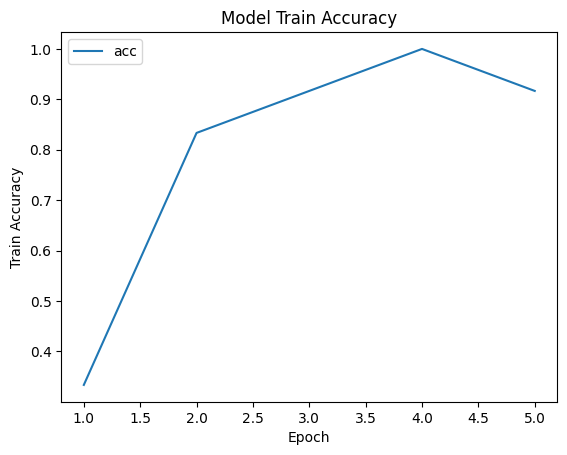

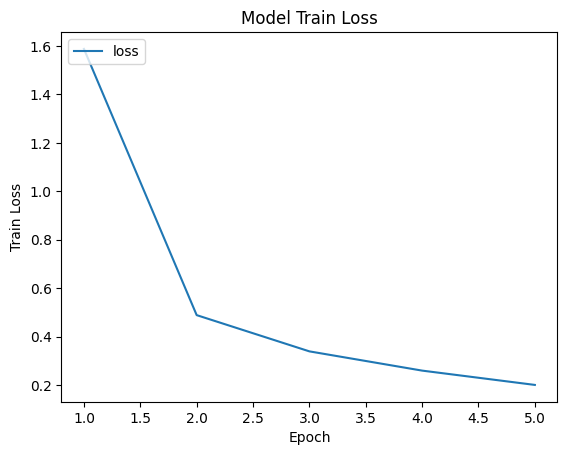

In [47]:
%matplotlib inline
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Train Accuracy',['acc'])
plot_graph(history_dataframe,'Model Train Loss','Epoch','Train Loss',['loss'])

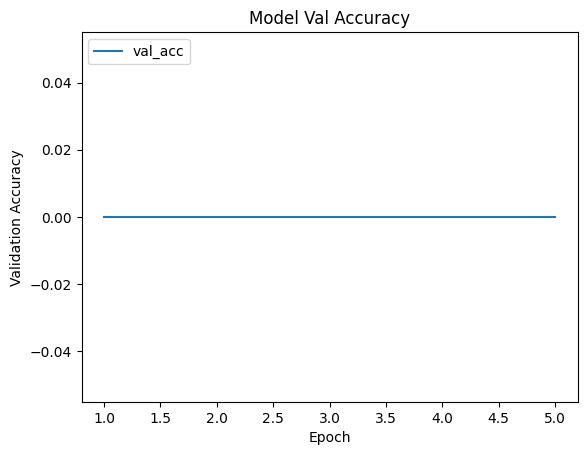

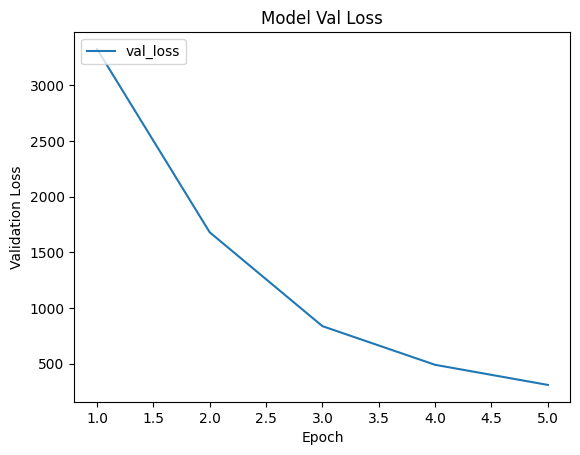

In [48]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_acc'])
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_loss'])